# Project

In this project, we consider the geospatial data.

In [55]:
import random

import osmnx as ox
import numpy as np
import geopandas as gpd
import pandana
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import networkx as nx

## 1. Finding the best location of a new 7-11 franchisee based on existing 7-11 locations and residential buildings (population)

In [56]:
def extract_graph(place):
    ox.config(log_console=True, use_cache=True)
    G = ox.graph_from_place(place, network_type='drive')
    return G
    
def extract_seven_elevens_buildings(place):
    ox.config(log_console=True, use_cache=True)
    
    # we only interested in building names and it's geometric information
    tags = {'building': ['residential']}
    all_buildings = ox.geometries_from_place(place, tags=tags)
    all_buildings = all_buildings[['name','geometry']]
    all_buildings = all_buildings[~(all_buildings['name'].isnull())]
    all_buildings = all_buildings[~(all_buildings['geometry'].isnull())]
    all_buildings['center'] = gpd.points_from_xy(x= all_buildings['geometry'].bounds[['minx','maxx']].mean(axis=1),y=all_buildings['geometry'].bounds[['miny','maxy']].mean(axis=1))
#     print("*"*50, len(all_buildings))
#     print("*"*50, all_buildings)
    
    tags = {'name': ['7-Eleven']}
    all_seven_elevens = ox.geometries_from_place(place, tags=tags)
    all_seven_elevens = all_seven_elevens[~(all_seven_elevens['name'].isnull())]
    all_seven_elevens = all_seven_elevens[~(all_seven_elevens['geometry'].isnull())]
    all_seven_elevens['center'] = gpd.points_from_xy(x= all_seven_elevens['geometry'].bounds[['minx','maxx']].mean(axis=1),y=all_seven_elevens['geometry'].bounds[['miny','maxy']].mean(axis=1))
#     print("*"*50, len(all_seven_elevens))
#     print("*"*50, all_seven_elevens)
    return all_seven_elevens,all_buildings

In [57]:
def get_seven_elevens_buildings(place):
    G = extract_graph(place)
    all_seven_elevens,all_buildings = extract_seven_elevens_buildings(place)

    # print("."*50, all_seven_elevens)
    node_seven_elevens  = ox.distance.nearest_nodes(G,X=all_seven_elevens['center'].x,Y = all_seven_elevens['center'].y)
    # print("/"*50, node_seven_elevens)

    # print("."*50, all_buildings)
    node_buildings  = ox.distance.nearest_nodes(G,X=all_buildings['center'].x,Y = all_buildings['center'].y)
    # print("/"*50, node_buildings)
    return all_seven_elevens, node_seven_elevens,all_buildings, node_buildings

In [58]:
def plot_seven_elevens_buildings(all_seven_elevens,all_buildings):
    # seven_eleven = all_seven_elevens.sample(10).iloc[0]
    # buildings = all_buildings.sample(10).iloc[0]

    # fig , ax = ox.plot_graph(G, bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa",show=False,close=False)
    # ax.scatter(all_seven_elevens['center'].x,all_seven_elevens['center'].y,c='g',marker="s",alpha=1,zorder=4)
    # ax.scatter(all_buildings['center'].x,all_buildings['center'].y,c='blue',alpha=1,zorder=3)

    # ax.scatter(all_buildings['center'].x, all_buildings['center'].y, c='blue',            alpha=1,zorder=3)
    #display(fig)

    # ax=all_seven_elevens.plot(cmap="RdYlBu", figsize=(15,15), legend=True)
    # ax=ox.plot_graph(G, ax=ax, bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa")
    # ax=all_buildings.plot(cmap="RdYlBu", figsize=(15,15), legend=True)
    # ax=ox.plot_graph(G, ax=ax, bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa")


    # ax=all_buildings.plot(cmap="RdYlBu", figsize=(15,15), legend=True)
    # fig,ax=ox.plot_graph(G, ax=ax, figsize=(15,15), bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa",show=False,close=False)
    fig,ax=ox.plot_graph(G,        figsize=(15,15), bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa",show=False,close=False)
    ax.scatter(all_seven_elevens['center'].x,   all_seven_elevens['center'].y,   c='g',    marker="s",alpha=1,zorder=4)
    ax.scatter(all_buildings['center'].x, all_buildings['center'].y, c='blue',            alpha=1,zorder=3)

In [59]:
def one_epoch(node_seven_elevens, node_buildings, learn_last=False, node_new=0):
    if not learn_last:
        K = len(node_seven_elevens)
    else:
        K = len(node_seven_elevens) + 1
    dist = np.zeros(K)
    number = np.zeros(K)
    neighbors = [[] for i in range(0, K)]
    for n, neighbor in enumerate(node_buildings):
        cloest_l = -1
        cloest_k = -1
        for k in range(0, K):
            if not learn_last or k < num_K - 1:
                center = node_seven_elevens[k]
            else:
                center = node_new
            # print("K, N", k, center)
            if nx.has_path(G, neighbor, center) and nx.has_path(G, center, neighbor):
                l = nx.shortest_path_length(G, source=neighbor, target=center)
                if cloest_k == -1 or l < cloest_l:
                    cloest_k = k
                    cloest_l = l
        if cloest_k != -1:
            # dist
            dist[cloest_k] += cloest_l
            # number
            number[cloest_k] += 1
            # neighbors
            neighbors[cloest_k].append(n)        
    return dist, number, neighbors

In [68]:
def Build711(place='Macau'):
    # get data
    all_seven_elevens, node_seven_elevens,all_buildings, node_buildings = get_seven_elevens_buildings(place)
    plot_seven_elevens_buildings(all_seven_elevens,all_buildings)
    
    # prepare training
    num_K = len(all_seven_elevens)+1
    num_N = len(all_buildings)
    print("num_K:", num_K)
    print("num_N:", num_N)
    # sample_building = all_buildings.sample(1)
    # node_new_x = sample_building['center'].x
    # node_new_y = sample_building['center'].y
    # node_new = ox.distance.nearest_nodes(G,X=new_SE_x,Y=new_SE_y)[0]
    node_new = node_buildings[random.randint(0, len(node_buildings) - 1)]
    print("node_new", node_new)
    
    # training
    decided = False
    for i in range(5):
        dist, number, neighbors = one_epoch(node_seven_elevens, node_buildings, learn_last=True, node_new=node_new)
        avg_dist = (dist+0) / (number+1)  # include self
        print("len(dist), dist.mean()", len(dist[number != 0]), dist[number != 0].mean())    
        print("avg_dist max", np.argmax(avg_dist), avg_dist.max())

        # check whether new location is effective
        neighbors_new = neighbors[-1]
        dist_new = dist[-1]
        avg_dist_new = avg_dist[-1]
        number_new = number[-1]
        print("dist_new avg_dist_new number_new", dist_new, avg_dist_new, number_new)
        # if len(neighbors_new) == 0:
        if not decided:
            decided = True
            print("*"*50)
            # if have not got an effective new location for 711, we locate it near by the most busy 711
            neighbors_busy = neighbors[np.argmax(avg_dist)]
            neighbor_new = neighbors_busy[random.randint(0, len(neighbors_busy) - 1)]
            node_new_x = all_buildings['center'][neighbor_new].x
            node_new_y = all_buildings['center'][neighbor_new].y
            node_new = node_buildings[neighbor_new]
        else:
            print("-"*50)
            # if have got an effective new location for 711, we refine its location by k means
            node_new_x = np.mean(all_buildings['center'][neighbors_new].x)
            node_new_y = np.mean(all_buildings['center'][neighbors_new].y)
            node_new = ox.distance.nearest_nodes(G,X=node_new_x,Y=node_new_y)
        print("node_new", node_new)
        
    # visulization
    fig,ax=ox.plot_graph(G,        figsize=(15,15), bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa",show=False,close=False)
    ax.scatter(
        node_new_x,   
        node_new_y,   
        c='g',    
        marker="s",
        alpha=1,
        zorder=4
    )
    ax.scatter(
        all_buildings['center'][neighbors[num_K -1]].x, 
        all_buildings['center'][neighbors[num_K -1]].y, 
        c='blue',            
        alpha=1,
        zorder=3
    )


    # metric
    print("-"*50, node_seven_elevens)
    dist, number, neighbors = one_epoch(node_seven_elevens, node_buildings)
    print("before: total dist", np.sum(dist))
    node_seven_elevens.append(node_new)
    dist, number, neighbors = one_epoch(node_seven_elevens, node_buildings)
    print("after total dist", np.sum(dist))

2022-05-19 18:32:53 Configured OSMnx 1.1.2
2022-05-19 18:32:53 HTTP response caching is on
2022-05-19 18:32:53 Retrieved response from cache file "cache/7302b1a1a554970a7aae66a37ab1d3a125087b11.json"
2022-05-19 18:32:53 Created GeoDataFrame with 1 rows from 1 queries
2022-05-19 18:32:53 Constructed place geometry polygon(s) to query API
2022-05-19 18:32:53 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-19 18:32:53 Projected GeoDataFrame to epsg:4326
2022-05-19 18:32:53 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-19 18:32:53 Projected GeoDataFrame to epsg:4326
2022-05-19 18:32:53 Requesting data within polygon from API in 1 request(s)
2022-05-19 18:32:53 Retrieved response from cache file "cache/ff1a5990518c10847f02b7fc0c6b9d23095a8162.json"
2022-05-19 18:32:53 Got all network data within polygon from API in 1 request(s)
2022-05-19 18:32:53 Creating graph from downl

/home/huangyuming/anaconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-05-19 18:32:53 Created graph with 23498 nodes and 29564 edges
2022-05-19 18:32:53 Added length attributes to graph edges
2022-05-19 18:32:53 Identifying all nodes that lie outside the polygon...
2022-05-19 18:32:54 Created nodes GeoDataFrame from graph
2022-05-19 18:32:54 Created r-tree spatial index for 23498 geometries
2022-05-19 18:32:54 Identified 22820 geometries inside polygon
2022-05-19 18:32:54 Removed 678 nodes outside polygon
2022-05-19 18:32:54 Truncated graph by polygon
2022-05-19 18:32:54 Begin topologically simplifying the graph...
2022-05-19 18:32:55 Identified 3456 edge endpoints
2022-05-19 18:32:55 Found 2 edges between 6219106949 and 4208824304 when simplifying
2022-05-19 18:32:55 Found 2 edges between 4208824304 and 4208824307 when simplifying
2022-05-19 18:32:55 Found 2 edges between 1832146625 and 1939314730 when simplifying
2022-05-19 18:32:55 Found 2 edges between 1939314730 and 1832146673 when simplifying
2022-05-19 18:32:55 Found 2 edges between 1832146673

/home/huangyuming/anaconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-05-19 18:32:56 323 geometries in the final GeoDataFrame
2022-05-19 18:32:56 Retrieved response from cache file "cache/7302b1a1a554970a7aae66a37ab1d3a125087b11.json"
2022-05-19 18:32:56 Created GeoDataFrame with 1 rows from 1 queries
2022-05-19 18:32:56 Constructed place geometry polygon(s) to query API
2022-05-19 18:32:56 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-19 18:32:56 Projected GeoDataFrame to epsg:4326
2022-05-19 18:32:56 Requesting data within polygon from API in 1 request(s)
2022-05-19 18:32:56 Retrieved response from cache file "cache/3208062aa142b9258b63ba1b19931f64befd9f55.json"
2022-05-19 18:32:56 Got all geometries data within polygon from API in 1 request(s)
2022-05-19 18:32:56 Converting 40 elements in JSON responses to geometries
2022-05-19 18:32:56 40 geometries created in the dict
2022-05-19 18:32:56 0 untagged geometries removed
2022-05-19 18:32:56 Created r-tree spatial index for 40 geometries
2

/home/huangyuming/anaconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-05-19 18:32:56 Created edges GeoDataFrame from graph


/home/huangyuming/anaconda3/envs/geospatial/lib/python3.8/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/home/huangyuming/anaconda3/envs/geospatial/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


2022-05-19 18:32:57 Created nodes GeoDataFrame from graph
2022-05-19 18:32:57 Finished plotting the graph
num_K: 41
num_N: 306
node_new 1754056403
len(dist), dist.mean() 39 62.256410256410255
avg_dist max 17 23.0
dist_new avg_dist_new number_new 0.0 0.0 1.0
**************************************************
node_new 2492640216
2022-05-19 18:33:06 Begin plotting the graph...
2022-05-19 18:33:06 Created edges GeoDataFrame from graph


/home/huangyuming/anaconda3/envs/geospatial/lib/python3.8/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/home/huangyuming/anaconda3/envs/geospatial/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


2022-05-19 18:33:07 Created nodes GeoDataFrame from graph
2022-05-19 18:33:07 Finished plotting the graph
-------------------------------------------------- [2169023906, 6040835453, 5543335567, 2157625970, 2027444154, 1793358410, 9004853901, 2486214926, 1867326940, 1846288224, 1754036977, 1758262871, 1754056425, 1754056421, 9519277096, 1754036975, 1937893684, 1941039624, 1942400761, 1942810205, 3536417231, 2168717760, 3121609540, 6308719038, 1846266736, 3121665344, 1942810197, 1449241485, 1449241483, 1846195341, 3355823826, 3109979756, 5105836446, 1809540500, 6361766988, 1942467224, 1937893685, 1754056408, 9026600201, 1938179570]
before: total dist 2429.0
total dist 2081.0


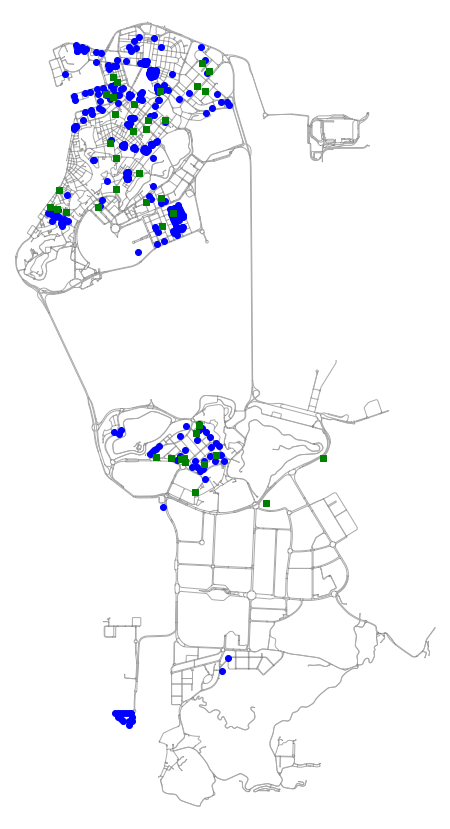

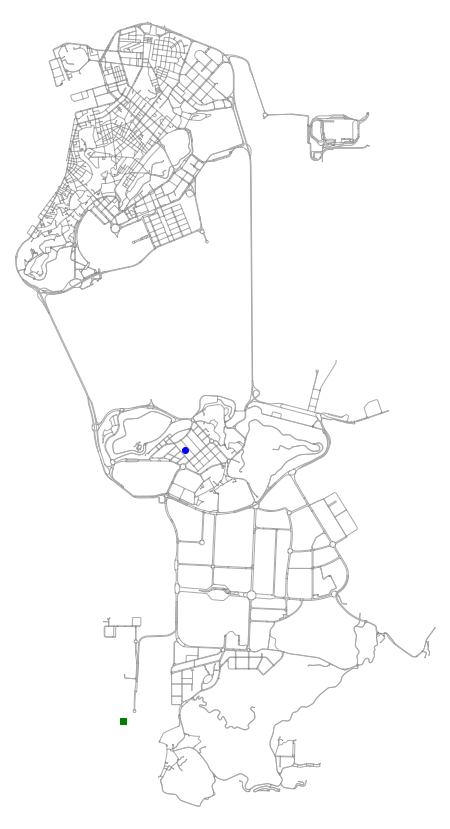

In [69]:
Build711(place='Macau')

In [ ]:
Build711(place="Beijing")

2022-05-19 18:36:02 Configured OSMnx 1.1.2
2022-05-19 18:36:02 HTTP response caching is on
2022-05-19 18:36:03 Pausing 1 seconds before making HTTP GET request
2022-05-19 18:36:04 Get https://nominatim.openstreetmap.org/search?format=json&polygon_geojson=1&dedupe=0&limit=50&q=Beijing with timeout=180
2022-05-19 18:36:04 Resolved nominatim.openstreetmap.org to 184.104.226.109
2022-05-19 18:36:05 Downloaded 130.0kB from nominatim.openstreetmap.org
2022-05-19 18:36:05 Saved response to cache file "cache/17c5f7fabc9b55ff8640592391a53a7511dbb2a0.json"


/home/huangyuming/anaconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-05-19 18:36:06 Created GeoDataFrame with 1 rows from 1 queries
2022-05-19 18:36:06 Constructed place geometry polygon(s) to query API
2022-05-19 18:36:06 Projected GeoDataFrame to +proj=utm +zone=50 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-19 18:36:06 Projected GeoDataFrame to epsg:4326
2022-05-19 18:36:06 Projected GeoDataFrame to +proj=utm +zone=50 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-19 18:36:06 Projected GeoDataFrame to epsg:4326
2022-05-19 18:36:06 Requesting data within polygon from API in 16 request(s)
2022-05-19 18:36:06 Resolved overpass-api.de to 178.63.11.215
2022-05-19 18:36:07 Pausing 0 seconds before making HTTP POST request
2022-05-19 18:36:07 Post https://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A180%5D%3B%28way%5B%22highway%22%5D%5B%22area%22%21~%22yes%22%5D%5B%22access%22%21~%22private%22%5D%5B%22highway%22%21~%22abandoned%7Cbridleway%7Cbus_guideway%7Cconstruction%7Ccorridor%7Ccycleway%7Celevat

2022-05-19 18:37:35 Downloaded 11,296.1kB from overpass-api.de
2022-05-19 18:37:35 Saved response to cache file "cache/cab7478ec15ed8f395990e1dfdb53b18e6a938dd.json"
2022-05-19 18:37:35 Resolved overpass-api.de to 178.63.11.215
2022-05-19 18:37:36 Pausing 11 seconds before making HTTP POST request
2022-05-19 18:37:47 Post https://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A180%5D%3B%28way%5B%22highway%22%5D%5B%22area%22%21~%22yes%22%5D%5B%22access%22%21~%22private%22%5D%5B%22highway%22%21~%22abandoned%7Cbridleway%7Cbus_guideway%7Cconstruction%7Ccorridor%7Ccycleway%7Celevator%7Cescalator%7Cfootway%7Cpath%7Cpedestrian%7Cplanned%7Cplatform%7Cproposed%7Craceway%7Cservice%7Csteps%7Ctrack%22%5D%5B%22motor_vehicle%22%21~%22no%22%5D%5B%22motorcar%22%21~%22no%22%5D%5B%22service%22%21~%22alley%7Cdriveway%7Cemergency_access%7Cparking%7Cparking_aisle%7Cprivate%22%5D%28poly%3A%2739.845090+116.983636+39.754067+116.983657+39.673810+116.905220+39.673464+116.904837+39.613041+116.8

2022-05-19 18:38:41 Downloaded 4,432.2kB from overpass-api.de
2022-05-19 18:38:41 Saved response to cache file "cache/6eab0a80d77f47c774c634d221d3267639b32d10.json"
2022-05-19 18:38:41 Resolved overpass-api.de to 178.63.11.215
2022-05-19 18:38:42 Pausing 7 seconds before making HTTP POST request
2022-05-19 18:38:49 Post https://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A180%5D%3B%28way%5B%22highway%22%5D%5B%22area%22%21~%22yes%22%5D%5B%22access%22%21~%22private%22%5D%5B%22highway%22%21~%22abandoned%7Cbridleway%7Cbus_guideway%7Cconstruction%7Ccorridor%7Ccycleway%7Celevator%7Cescalator%7Cfootway%7Cpath%7Cpedestrian%7Cplanned%7Cplatform%7Cproposed%7Craceway%7Cservice%7Csteps%7Ctrack%22%5D%5B%22motor_vehicle%22%21~%22no%22%5D%5B%22motorcar%22%21~%22no%22%5D%5B%22service%22%21~%22alley%7Cdriveway%7Cemergency_access%7Cparking%7Cparking_aisle%7Cprivate%22%5D%28poly%3A%2740.242757+115.566214+40.539045+115.741299+40.539420+115.741544+40.539776+115.741834+40.540109+115.742